In [1]:
import random
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

import wandb
import networkx as nx
from pyvis.network import Network

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import knn_graph, radius_graph

In [2]:
pre_transform = T.NormalizeScale()
transform = T.SamplePoints(128)
low_train_dataset = ModelNet(
    root="ModelNet10",
    name='10',
    train=True,
    transform=transform,
    pre_transform=pre_transform
)

pre_transform = T.NormalizeScale()
transform = T.SamplePoints(2048)
high_train_dataset = ModelNet(
    root="ModelNet10",
    name='10',
    train=True,
    transform=transform,
    pre_transform=pre_transform
)

wandb: Currently logged in as: geekyrakshit. Use `wandb login --relogin` to force relogin


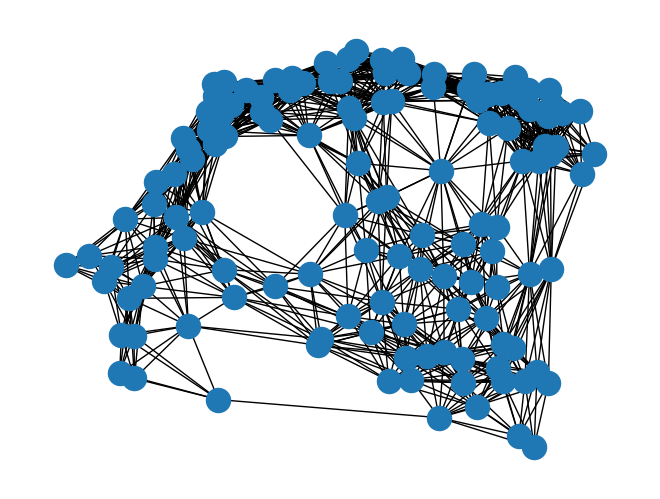

In [3]:
with wandb.init(
    project="pyg-point-cloud",
    name="sampling/modelnet10",
    entity="geekyrakshit",
    job_type="eda"
):
    table = wandb.Table(columns=[
        "Model", "KNN-Sampled-Subgraph", "Nearest-Neighbours", "Radius-Sampled-Subgraph", "Radius"
    ])
        
    sample_data = low_train_dataset[0]

    sample_data.edge_index = knn_graph(sample_data.pos, k=6)
    G = to_networkx(sample_data, to_undirected=True)
    nt = Network('500px', '500px')
    nt.from_nx(G)
    knn_sampled = wandb.Html(nt.generate_html())

    sample_data = low_train_dataset[0]
    sample_data.edge_index = radius_graph(sample_data.pos, r=0.5)
    G = to_networkx(sample_data, to_undirected=True)
    nx.draw(G)
    nt = Network('500px', '500px')
    nt.from_nx(G)
    radius_sampled = wandb.Html(nt.generate_html())
    
    table.add_data(
        wandb.Object3D(high_train_dataset[0].pos.numpy()), knn_sampled, 6, radius_sampled, 0.
    )
    
    wandb.log({"Sampling-Comparison": table})